In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Dropout,
    Input,
    AveragePooling2D,
    Activation,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Concatenate,
)
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19, EfficientNetV2L, MobileNetV2
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2022-12-05 20:22:48--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.48.252, 2600:1413:b000:793::317f, 2600:1413:b000:78a::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.48.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   276MB/s    in 2.8s    

2022-12-05 20:22:50 (276 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
import zipfile
with zipfile.ZipFile("/content/kagglecatsanddogs_5340.zip", 'r') as zip_ref:
    zip_ref.extractall("cats_and_dogs")

In [ ]:
import glob
import os
img_paths = glob.glob(os.path.join('/content/cats_and_dogs/PetImages','*/*.*')) # assuming you point to the directory containing the label folders.

bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)

    print(f"{image_path}: OK")

print("BAD PATHS:")
for bad_path in bad_paths:
    print(f"{bad_path}")

Streaming output truncated to the last 5000 lines.
/content/cats_and_dogs/PetImages/Dog/8018.jpg: OK
/content/cats_and_dogs/PetImages/Dog/8910.jpg: OK
/content/cats_and_dogs/PetImages/Dog/381.jpg: OK
/content/cats_and_dogs/PetImages/Dog/10320.jpg: OK
/content/cats_and_dogs/PetImages/Dog/9130.jpg: OK
/content/cats_and_dogs/PetImages/Dog/49.jpg: OK
/content/cats_and_dogs/PetImages/Dog/4558.jpg: OK
/content/cats_and_dogs/PetImages/Dog/6102.jpg: OK
/content/cats_and_dogs/PetImages/Dog/4922.jpg: OK
/content/cats_and_dogs/PetImages/Dog/11405.jpg: OK
/content/cats_and_dogs/PetImages/Dog/3468.jpg: OK
/content/cats_and_dogs/PetImages/Dog/10991.jpg: OK
/content/cats_and_dogs/PetImages/Dog/1343.jpg: OK
/content/cats_and_dogs/PetImages/Dog/2325.jpg: OK
/content/cats_and_dogs/PetImages/Dog/5861.jpg: OK
/content/cats_and_dogs/PetImages/Dog/2668.jpg: OK
/content/cats_and_dogs/PetImages/Dog/9323.jpg: OK
/content/cats_and_dogs/PetImages/Dog/6732.jpg: OK
/content/cats_and_dogs/PetImages/Dog/8834.jpg: OK

Corrupted Files:

BAD PATHS:

    /content/cats_and_dogs/PetImages/Cat/10404.jpg
    /content/cats_and_dogs/PetImages/Cat/4351.jpg
    /content/cats_and_dogs/PetImages/Cat/666.jpg
    /content/cats_and_dogs/PetImages/Cat/Thumbs.db
    /content/cats_and_dogs/PetImages/Dog/2317.jpg
    /content/cats_and_dogs/PetImages/Dog/11702.jpg
    /content/cats_and_dogs/PetImages/Dog/11912.jpg
    /content/cats_and_dogs/PetImages/Dog/9500.jpg
    /content/cats_and_dogs/PetImages/Dog/Thumbs.db
    /content/cats_and_dogs/PetImages/Dog/11233.jpg
    /content/cats_and_dogs/PetImages/Dog/2494.jpg





In [ ]:
bad_paths

['/content/cats_and_dogs/PetImages/Cat/10404.jpg',
 '/content/cats_and_dogs/PetImages/Cat/Thumbs.db',
 '/content/cats_and_dogs/PetImages/Cat/666.jpg',
 '/content/cats_and_dogs/PetImages/Cat/4351.jpg',
 '/content/cats_and_dogs/PetImages/Dog/2494.jpg',
 '/content/cats_and_dogs/PetImages/Dog/11912.jpg',
 '/content/cats_and_dogs/PetImages/Dog/2317.jpg',
 '/content/cats_and_dogs/PetImages/Dog/11702.jpg',
 '/content/cats_and_dogs/PetImages/Dog/Thumbs.db',
 '/content/cats_and_dogs/PetImages/Dog/9500.jpg',
 '/content/cats_and_dogs/PetImages/Dog/11233.jpg']

In [ ]:
import os
for path in bad_paths:
  if os.path.exists(path):
    os.remove(path)
  else:
    print("The file does not exist") 

In [ ]:
train_data = image_dataset_from_directory(
    "/content/cats_and_dogs/PetImages",
    labels="inferred",
    label_mode = 'int',
    seed=0,
    validation_split=0.2,
    subset="training"
)

Found 24991 files belonging to 2 classes.
Using 19993 files for training.


In [ ]:
test_data = image_dataset_from_directory(
    "/content/cats_and_dogs/PetImages",
    labels="inferred",
    label_mode = 'int',
    seed=0,
    validation_split=0.2,
    subset="validation"
)

Found 24991 files belonging to 2 classes.
Using 4998 files for validation.


In [ ]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_data.map(process)
test_ds = test_data.map(process)

In [ ]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(
  train_ds,
  epochs=10,
  batch_size = 32,
  validation_data=test_ds,
  callbacks=[callback]
  )

Epoch 1/10
625/625 [==============================] - 82s 116ms/step - loss: 1.4311 - accuracy: 0.5852 - val_loss: 0.6576 - val_accuracy: 0.6080
Epoch 2/10
625/625 [==============================] - 72s 114ms/step - loss: 0.5863 - accuracy: 0.6989 - val_loss: 0.5161 - val_accuracy: 0.7491
Epoch 3/10
625/625 [==============================] - 80s 128ms/step - loss: 0.4918 - accuracy: 0.7671 - val_loss: 0.4994 - val_accuracy: 0.7597
Epoch 4/10
625/625 [==============================] - 73s 116ms/step - loss: 0.4310 - accuracy: 0.8071 - val_loss: 0.4333 - val_accuracy: 0.7919
Epoch 5/10
625/625 [==============================] - 74s 118ms/step - loss: 0.3679 - accuracy: 0.8377 - val_loss: 0.4754 - val_accuracy: 0.7679
Epoch 6/10
625/625 [==============================] - 71s 114ms/step - loss: 0.2970 - accuracy: 0.8711 - val_loss: 0.4010 - val_accuracy: 0.8203
Epoch 7/10
625/625 [==============================] - 75s 120ms/step - loss: 0.2279 - accuracy: 0.9041 - val_loss: 0.4689 - val_ac

In [ ]:
# Reading image labels from image_dataset_from_dir
train_label = np.concatenate([y for x, y in train_data], axis=0)
test_label = np.concatenate([y for x, y in test_data], axis=0) 

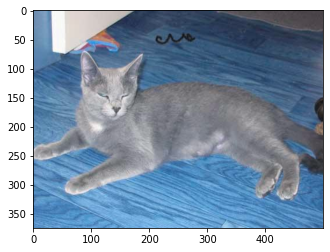

In [ ]:
import cv2
test_img = cv2.imread('/content/cats_and_dogs/PetImages/Cat/10008.jpg')
plt.imshow(test_img)

In [ ]:
test_img = cv2.resize(test_img,(256,256))
exp_img = np.expand_dims(test_img, 0)
model.predict(exp_img)

1/1 [==============================] - 0s 16ms/step


array([1.], dtype=float32)

In [ ]:
from PIL import Image
from tensorflow.image import resize
image = Image.open('/content/cats_and_dogs/PetImages/Cat/10008.jpg')

In [ ]:
resized_img = resize(image, (256, 256)).numpy().astype(int)
exp_img = np.expand_dims(resized_img, 0)
y_prob = model.predict(exp_img)
if y_prob.max(axis=-1) < 0.5:
    return "Cannot predict. Please provide appropriate image."
else:
    y_classes = y_prob.argmax(axis=-1)
